# Conditional Convolutional GANs

### Implementation of cGAN on MNIST data

Original [Paper](https://arxiv.org/abs/1411.1784) was based on MLP but we'll tweak it here to use convolutional DLLs, so the model below is **Convolutional cGAN**.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU, Conv2D, MaxPool2D, UpSampling2D, Flatten, Reshape, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers.legacy import Adam

from tqdm.notebook import tqdm
from helper_functions import one_hot_encoding, plot_images
import numpy as np
from sys import platform
import os

## Set Backend Device

In [2]:
if tf.test.gpu_device_name():
    print(f'Default GPU Device: {tf.test.gpu_device_name()}')

Default GPU Device: /device:GPU:0


2023-09-18 16:02:38.065805: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-09-18 16:02:38.065828: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-09-18 16:02:38.065833: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-09-18 16:02:38.065869: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-18 16:02:38.065885: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-09-18 16:02:38.066773: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been buil

In [3]:
# Stop the default logging output
tf.keras.utils.disable_interactive_logging()

# Set the float pricision to 32bits to reduce memory usage
tf.keras.backend.set_floatx('float32')

## Define Global Parameters

In [4]:
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
BATCH_SIZE = 128
LATENT_DIMENSION = 150
EPOCH_ITERATIONS = 150
EPOCHS = 200

## Model

In [5]:
class cGAN:
    def __init__(self, img_width, img_height, batch_size, latent_dim, epochs):
        """
            params:
            -------
                * img_width : Width of the image
                * img_height : Height of the image
                * batch_size : batch size
                * latent_dim : dimension of the latent vector
                * epochs : number of epochs
            returns:
            --------
                * cGAN Object
        """
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.img_shape = (img_width, img_height)
        self.epochs = epochs
        self.digit_encoding = one_hot_encoding()

        ######################################
        #   Define the Computational Graph   #
        ######################################
        self.gen = self.__build_generator()
        self.discrim = self.__build_discriminator()

        self.generator_loss_history, self.discriminator_loss_history = [], []
        self.discrim.compile(loss = 'binary_crossentropy', optimizer = Adam(0.0002, 0.4), metrics=['accuracy'])
        
        self.discrim.trainable = False
        
        inp = Input(shape=self.latent_dim, name="latent")
        label = Input(shape=10, name="label")
        gen_in = Concatenate(axis = 1)([inp, label])
        gen_out = Reshape((np.prod(self.img_shape),))(self.gen(gen_in))
        gen_out = Concatenate(axis = 1)([gen_out, label])
        
        # feed into discriminator
        discrim_out = self.discrim(gen_out)
        
        self.combined = Model([inp, label], discrim_out, name="combined_model")
        self.combined.compile(loss = 'binary_crossentropy', optimizer = Adam(0.0002, 0.4), metrics=['accuracy'])
    
    def train(self):
        """
            Training Function which loads the data & trains the model
        """
        (x_train, y_train), (_, _) = mnist.load_data()
        x_train = (x_train.astype(np.float32) - 127.5) / 127.5
        half_batch = int(self.batch_size/2)

        # FOR EACH EPOCH we'll train on EPOCH_ITERATIONS*BATCH_SIZE data points
        for epoch in tqdm(range(1, self.epochs + 1)):
            for i in range(EPOCH_ITERATIONS):
                # select some random images (batch_size)
                idx = np.random.randint(0, x_train.shape[0], half_batch)
                imgs = x_train[idx].reshape((half_batch, np.prod(self.img_shape)))
                labels = np.array([self.digit_encoding[i] for i in y_train[idx]])
                
                ### LABEL (True : Real Images)
                y_imgs = np.ones(half_batch)

                # Noise to be fed into generator
                rand_noise = np.random.normal(0, 1, (half_batch, self.latent_dim))
                rand_noise = np.concatenate([rand_noise, labels], axis = 1)

                # Also after generating images, convert them to real image shape (drop additional dim)
                gen_imgs = self.gen.predict([rand_noise]).reshape((half_batch, np.prod(self.img_shape)))
                gen_imgs = np.concatenate([gen_imgs, labels], axis = 1)#.reshape((half_batch, *self.img_shape))
                imgs = np.concatenate([imgs, labels], axis = 1)
                ### LABEL (False : Fake Images)
                y_gen_imgs = np.zeros(half_batch)
                
                imgs = np.concatenate([imgs, gen_imgs])
                y_imgs = np.concatenate([y_imgs, y_gen_imgs])
                
                # Shuffle
                indices = np.arange(self.batch_size)
                np.random.shuffle(indices)
                
                imgs = imgs[indices]
                y_imgs = y_imgs[indices]

                # Disciminator loss
                d_loss = self.discrim.train_on_batch([imgs], y_imgs)
                
                if i-EPOCH_ITERATIONS == -1:
                    # Store on loss on the last iteration
                    self.discriminator_loss_history.append(d_loss)
            
            for i in range(EPOCH_ITERATIONS):
                # Noise to be fed into generator
                rand_noise = np.random.normal(0, 1, (self.batch_size, self.latent_dim))
                labels = np.array([self.digit_encoding[i] for i in np.random.randint(0, 10, self.batch_size)])

                y_gen_imgs = np.ones(self.batch_size)

                # Train the generator
                g_loss = self.combined.train_on_batch([rand_noise, labels], y_gen_imgs)
                if i-EPOCH_ITERATIONS == -1:
                    # Store on loss on the last iteration
                    self.generator_loss_history.append(g_loss)
            
            if epoch % 40 == 0:
                # Generate some images during the training phase
                print(f"############################## EPOCH : {epoch} ##############################")
                generated_images, labels = self.generate_some_imgs()
                
                # perform reverse lookup on labels
                new_labels = []
                for i in labels:
                    for idx, val in enumerate(i):
                        if val == 1:
                            new_labels.append(idx)
                            break
                plot_images(2, 5, (10, 5), generated_images, new_labels, cmap='gray')
                
    ############ CLASS HELPER FUNCTIONS ############
    def get_losses(self):
        """
            returns the loss values
        """
        return self.generator_loss_history, self.discriminator_loss_history
    
    def generate_some_imgs(self, num = 10):
        """
            Helper function which takes a random noise and generates some images from the generator
        """
        rand_noise = np.random.normal(0, 1, (num, self.latent_dim))
        labels = np.array([self.digit_encoding[i] for i in np.random.randint(0, 10, num)])
        rand_noise = np.concatenate([rand_noise, labels], axis = 1)

        return self.gen.predict([rand_noise]), labels
    
    def get_discriminator_summary(self):
        """
        Helper function to get discriminator model summary
        """
        self.discrim.summary()
    
    def get_generator_summary(self):
        """
        Helper function to get generator model summary
        """
        self.gen.summary()
    
    def get_full_summary(self):
        self.combined.summary()

    def __build_discriminator(self):
        discriminator = Sequential([
            Dense(529, input_shape=(np.prod(self.img_shape)+10, )),
            LeakyReLU(alpha=0.3),
            Dropout(0.2),
            Reshape((23, 23, -1)),
            Conv2D(filters = 80, kernel_size=(3, 3), padding='same'),
            LeakyReLU(alpha=0.3),
            Dropout(0.2),
            MaxPool2D(pool_size=(3, 3), strides=1),
            Conv2D(filters = 40, kernel_size=(3, 3), padding='same'),
            LeakyReLU(alpha=0.3),
            Dropout(0.2),
            MaxPool2D(pool_size=(2, 2), strides=2),
            Conv2D(filters = 10, kernel_size=(3, 3), padding='same'),
            LeakyReLU(alpha=0.3),
            MaxPool2D(pool_size=(3, 3), strides=2),
            Dropout(0.3),
            Flatten(),
            Dense(1, activation = 'sigmoid')
        ], name = 'Discriminator')
        return discriminator
    
    def __build_generator(self):
        generator = Sequential([
            Dense(3136, input_dim = self.latent_dim + 10), # + 10 for one-hot encoding of the 10 digits
            LeakyReLU(alpha=0.3),
            Reshape((7, 7,-1)),
            UpSampling2D(),
            Conv2DTranspose(filters = 50, kernel_size=(3,3), padding='same', activation='tanh'),
            Dropout(0.3),
            Conv2DTranspose(filters = 20, kernel_size=(3,3), strides=(2, 2), padding='same', activation='tanh'),
            Dropout(0.3),
            Conv2DTranspose(1, kernel_size=(4,4), padding='same', activation='tanh')
        ], name = 'Generator')
        return generator

In [6]:
my_cGAN = cGAN(IMAGE_WIDTH, IMAGE_HEIGHT, BATCH_SIZE, LATENT_DIMENSION, EPOCHS)

2023-09-18 16:02:38.157121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-18 16:02:38.157140: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


  0%|          | 0/200 [00:00<?, ?it/s]

2023-09-18 16:02:38.608596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 16:02:38.857975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 16:02:45.946776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


############################## EPOCH : 40 ##############################


2023-09-18 16:09:26.820950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


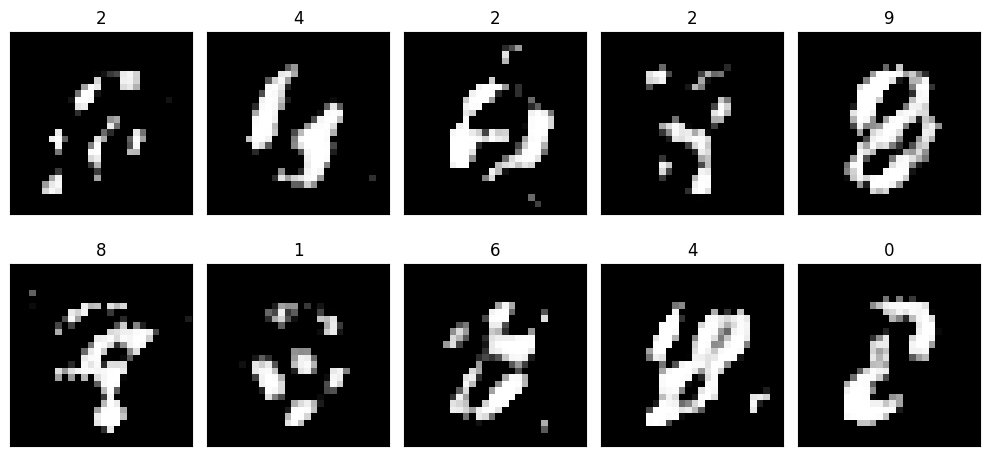

############################## EPOCH : 80 ##############################


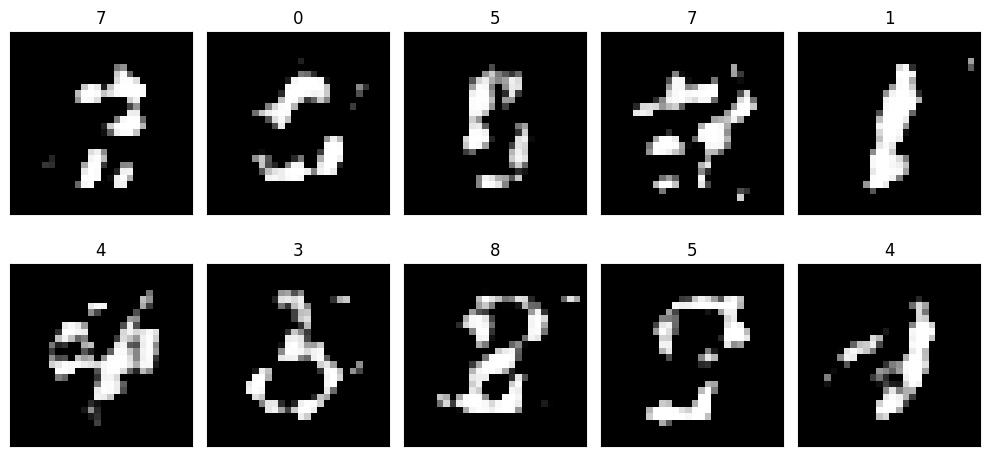

############################## EPOCH : 120 ##############################


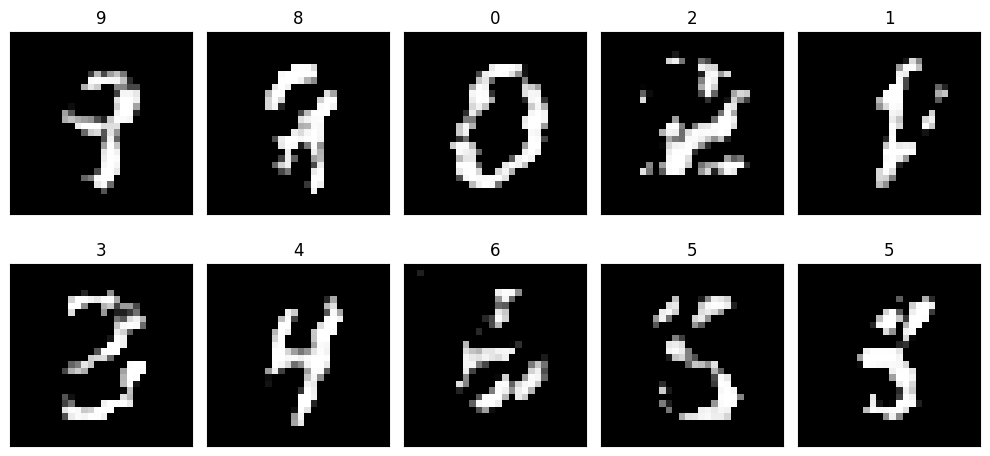

############################## EPOCH : 160 ##############################


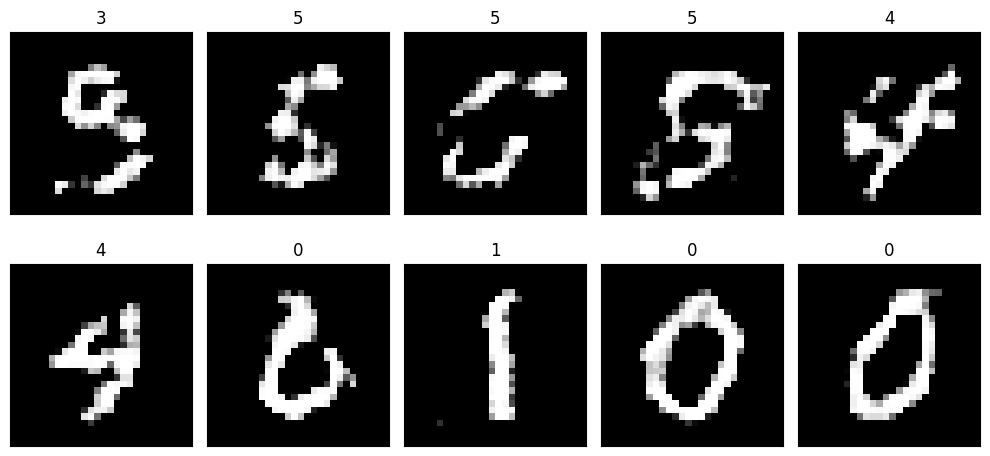

############################## EPOCH : 200 ##############################


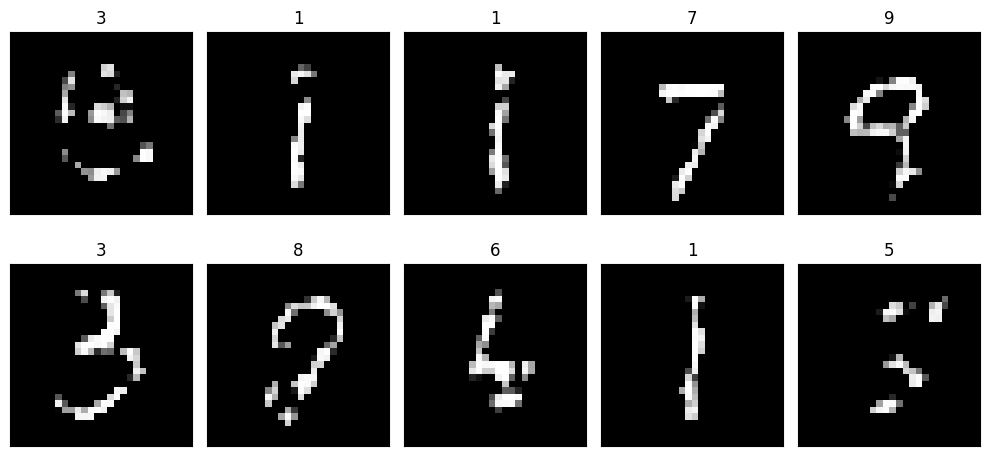

In [7]:
my_cGAN.train()

In [8]:
if platform == "darwin":
    os.system("say 'Model Training DONE!'")

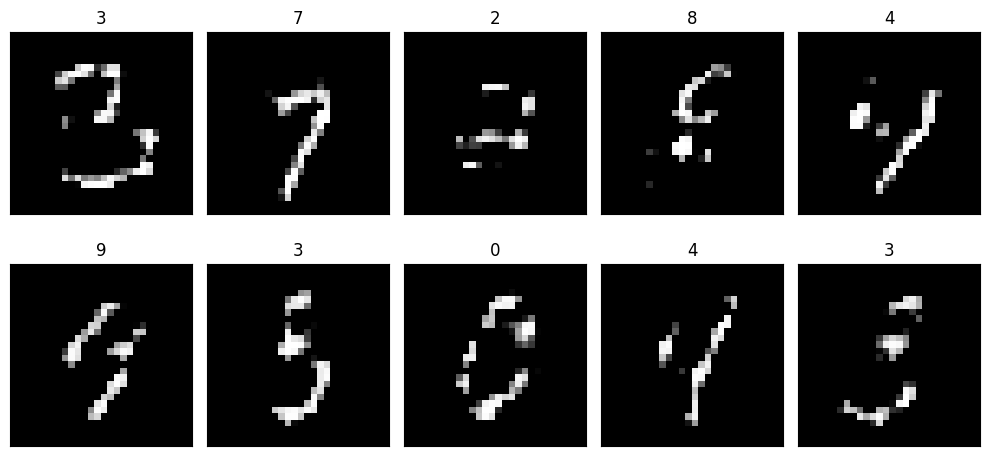

In [15]:
imgs, labels = my_cGAN.generate_some_imgs()
new_labels = []
for i in labels:
    for idx, val in enumerate(i):
        if val == 1:
            new_labels.append(idx)
            break
plot_images(2, 5, (10, 5),imgs, new_labels, cmap = 'gray')